## Import Libraries

In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import pandas as pd
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import mplcursors
from pylab import rcParams
import seaborn as sns
import mplfinance as mpf
import datetime as dt
import time
from pylab import rcParams
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import Common_Functions as cf

%matplotlib inline

N = 21
test_size = 0.25

#### Read Dataframe

In [2]:
AAPL_df = pd.read_csv('AAPL.csv', parse_dates = True, index_col = 0)
AAPL_df.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE
0,2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857
1,2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071
2,2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448
3,2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188
4,2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.076317


In [3]:
AAPL_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5121 entries, 0 to 5120
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       5121 non-null   object 
 1   HIGH       5121 non-null   float64
 2   LOW        5121 non-null   float64
 3   OPEN       5121 non-null   float64
 4   CLOSE      5121 non-null   float64
 5   VOLUME     5121 non-null   float64
 6   ADJ_CLOSE  5121 non-null   float64
dtypes: float64(6), object(1)
memory usage: 320.1+ KB


In [4]:
AAPL_df.loc[:, 'DATE'] = pd.to_datetime(AAPL_df['DATE'], format = '%Y-%m-%d')

In [5]:
AAPL_df.dtypes

DATE         datetime64[ns]
HIGH                float64
LOW                 float64
OPEN                float64
CLOSE               float64
VOLUME              float64
ADJ_CLOSE           float64
dtype: object

#### Preliminary Graph of Dataframe

In [6]:
style.use('seaborn-darkgrid')

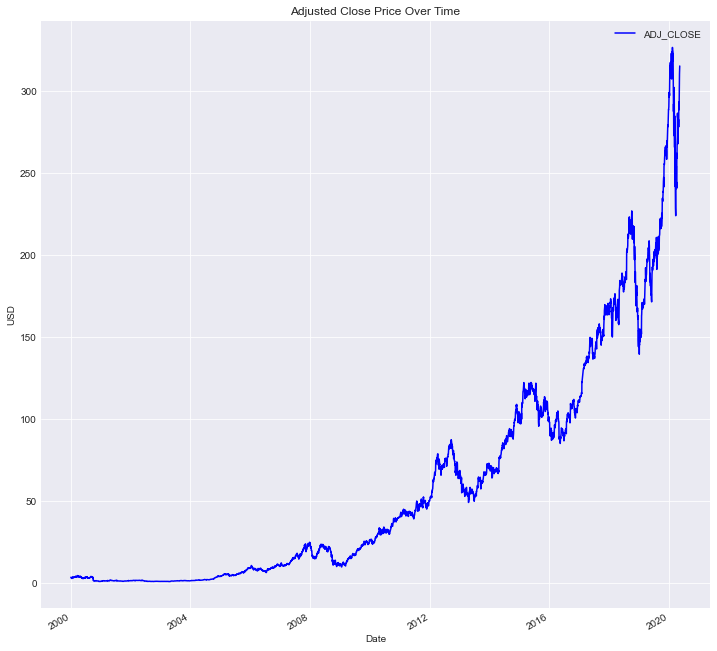

In [7]:
rcParams['figure.figsize'] = 12, 12

ax = AAPL_df.plot(x = 'DATE', y = 'ADJ_CLOSE', style = 'b-', grid = True)
ax.set_ylabel('USD')
ax.set_xlabel('Date')
ax.set_title('Adjusted Close Price Over Time');

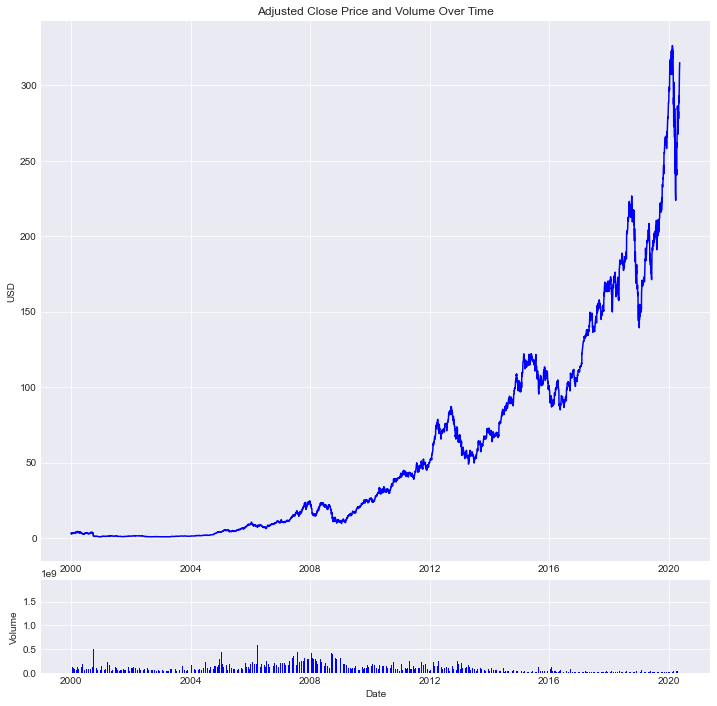

In [8]:
rcParams['figure.figsize'] = 12, 12

ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

ax1.plot(AAPL_df['DATE'], AAPL_df['ADJ_CLOSE'], 'b-')
ax1.set_ylabel('USD')
ax1.set_title('Adjusted Close Price and Volume Over Time')
ax1.grid(True)

ax2.bar(AAPL_df['DATE'], AAPL_df['VOLUME'], color = 'blue')
ax2.grid(True)
ax2.set_ylabel('Volume')

plt.xlabel('Date')

plt.show()

#### Dataframe Manipulation

In [9]:
AAPL_df['MONTH'] = AAPL_df['DATE'].dt.month
AAPL_df['RANGE_HL'] = AAPL_df['HIGH'] - AAPL_df['LOW']
AAPL_df['RANGE_OC'] = AAPL_df['OPEN'] - AAPL_df['CLOSE']
AAPL_df.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,MONTH,RANGE_HL,RANGE_OC
0,2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857,1,0.386161,-0.252232
1,2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071,1,0.337054,0.205357
2,2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448,1,0.270089,-0.008929
3,2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188,1,0.428571,0.397321
4,2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.076317,1,0.196429,-0.107143


In [10]:
AAPL_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5121 entries, 0 to 5120
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       5121 non-null   datetime64[ns]
 1   HIGH       5121 non-null   float64       
 2   LOW        5121 non-null   float64       
 3   OPEN       5121 non-null   float64       
 4   CLOSE      5121 non-null   float64       
 5   VOLUME     5121 non-null   float64       
 6   ADJ_CLOSE  5121 non-null   float64       
 7   MONTH      5121 non-null   int64         
 8   RANGE_HL   5121 non-null   float64       
 9   RANGE_OC   5121 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 440.1 KB


# Split Data into Train and Test Data Frames (manual)

In [11]:
AAPL_df['ORDER'] = [x for x in list(range(len(AAPL_df)))]

merging_col = ['ORDER']

lag_cols = ['OPEN', 'CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']
lag_cols

['OPEN', 'CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']

In [12]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm(shift_range):
    train_shift = AAPL_df[merging_col + lag_cols].copy()
    
    train_shift['ORDER'] = train_shift['ORDER'] + shift
    
    col_name = lambda x: '{}_LAG_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns = col_name)
    
    AAPL_df = pd.merge(AAPL_df, train_shift, on = merging_col, how = 'left')
    
del train_shift

AAPL_df = AAPL_df[N:]

AAPL_df.head()

<ipython-input-12-e775ed8bcc17>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm(shift_range):


,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,MONTH,RANGE_HL,RANGE_OC,...,OPEN_LAG_20,CLOSE_LAG_20,VOLUME_LAG_20,RANGE_HL_LAG_20,RANGE_OC_LAG_20,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21
21,2000-02-02,3.647321,3.464286,3.598214,3.529018,116048800.0,3.055062,2,0.183036,0.069196,...,3.866071,3.660714,128094400.0,0.337054,0.205357,3.745536,3.997768,133949200.0,0.386161,-0.252232
22,2000-02-03,3.723214,3.580357,3.582589,3.689732,118798400.0,3.194192,2,0.142857,-0.107143,...,3.705357,3.714286,194580400.0,0.270089,-0.008929,3.866071,3.660714,128094400.0,0.337054,0.205357
23,2000-02-04,3.928571,3.700893,3.712054,3.857143,106330000.0,3.339118,2,0.227679,-0.145089,...,3.790179,3.392857,191993200.0,0.428571,0.397321,3.705357,3.714286,194580400.0,0.270089,-0.008929
24,2000-02-07,4.080357,3.783482,3.857143,4.073661,110266800.0,3.526558,2,0.296875,-0.216518,...,3.446429,3.553571,115183600.0,0.196429,-0.107143,3.790179,3.392857,191993200.0,0.428571,0.397321
25,2000-02-08,4.147321,3.973214,4.071429,4.102679,102160800.0,3.551679,2,0.174107,-0.031250,...,3.642857,3.491071,126266000.0,0.267857,0.151786,3.446429,3.553571,115183600.0,0.196429,-0.107143


In [13]:
for col in lag_cols:
    AAPL_df = cf.get_mov_avg_std(AAPL_df, col)
    
AAPL_df = cf.get_mov_avg_std(AAPL_df, 'ADJ_CLOSE')
    
AAPL_df.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,MONTH,RANGE_HL,RANGE_OC,...,CLOSE_MEAN,CLOSE_STD,VOLUME_MEAN,VOLUME_STD,RANGE_HL_MEAN,RANGE_HL_STD,RANGE_OC_MEAN,RANGE_OC_STD,ADJ_CLOSE_MEAN,ADJ_CLOSE_STD
21,2000-02-02,3.647321,3.464286,3.598214,3.529018,116048800.0,3.055062,2,0.183036,0.069196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2000-02-03,3.723214,3.580357,3.582589,3.689732,118798400.0,3.194192,2,0.142857,-0.107143,...,3.529018,NaN,1.160488e+08,NaN,0.183036,NaN,0.069196,NaN,3.055062,NaN
23,2000-02-04,3.928571,3.700893,3.712054,3.857143,106330000.0,3.339118,2,0.227679,-0.145089,...,3.609375,0.113642,1.174236e+08,1.944261e+06,0.162947,0.028411,-0.018973,0.124691,3.124627,0.098380
24,2000-02-07,4.080357,3.783482,3.857143,4.073661,110266800.0,3.526558,2,0.296875,-0.216518,...,3.691964,0.164074,1.137257e+08,6.550781e+06,0.184524,0.042430,-0.061012,0.114349,3.196124,0.142038
25,2000-02-08,4.147321,3.973214,4.071429,4.102679,102160800.0,3.551679,2,0.174107,-0.031250,...,3.787388,0.233174,1.128610e+08,5.621347e+06,0.212612,0.065999,-0.099888,0.121502,3.278733,0.201857


In [14]:
num_test = int(test_size * len(AAPL_df))
num_train = len(AAPL_df) - num_test
print('num_train:', str(num_train))
print('num_test:', str(num_test))
print('')

train = AAPL_df[:num_train]
test = AAPL_df[num_train:]
print('train.shape:', str(train.shape))
print('test.shape:', str(test.shape))

num_train: 3825
num_test: 1275

train.shape: (3825, 128)
test.shape: (1275, 128)


In [15]:
scaling_cols = ['ADJ_CLOSE']

for num in range(1, N+1):
    scaling_cols.append('OPEN_LAG_'+str(num))
    scaling_cols.append('CLOSE_LAG_'+str(num))
    scaling_cols.append('VOLUME_LAG_'+str(num))
    scaling_cols.append('RANGE_HL_LAG_'+str(num))
    scaling_cols.append('RANGE_OC_LAG_'+str(num))
    
scaler = StandardScaler()
train_scale = scaler.fit_transform(train[scaling_cols])
train_df_scaled = pd.DataFrame(train_scale, columns = scaling_cols)
train_df_scaled[['DATE']] = train.reset_index()[['DATE']]
train_df_scaled.head()

,ADJ_CLOSE,OPEN_LAG_1,CLOSE_LAG_1,VOLUME_LAG_1,RANGE_HL_LAG_1,RANGE_OC_LAG_1,OPEN_LAG_2,CLOSE_LAG_2,VOLUME_LAG_2,RANGE_HL_LAG_2,...,CLOSE_LAG_20,VOLUME_LAG_20,RANGE_HL_LAG_20,RANGE_OC_LAG_20,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21,DATE
0,-0.784677,-0.789180,-0.793254,-0.598077,-0.633169,0.195794,-0.792279,-0.789310,0.356337,-0.425528,...,-0.788104,-0.120401,-0.415278,0.320216,-0.785416,-0.777554,-0.062319,-0.349093,-0.446356,2000-02-02
1,-0.779967,-0.792699,-0.794811,-0.234341,-0.627242,0.088984,-0.789027,-0.793106,-0.598546,-0.632943,...,-0.786446,0.541861,-0.504986,-0.038960,-0.781683,-0.787998,-0.120645,-0.414900,0.321046,2000-02-03
2,-0.775059,-0.793173,-0.789936,-0.206970,-0.680577,-0.201979,-0.792550,-0.794665,-0.234757,-0.627016,...,-0.796395,0.516090,-0.292677,0.641979,-0.786661,-0.786338,0.541693,-0.504637,-0.038323,2000-02-04
3,-0.768713,-0.789248,-0.784857,-0.331086,-0.567981,-0.264592,-0.793024,-0.789785,-0.207382,-0.680352,...,-0.791420,-0.249005,-0.603665,-0.203583,-0.784034,-0.796298,0.515920,-0.292259,0.642981,2000-02-07
4,-0.767862,-0.784849,-0.778289,-0.291897,-0.476126,-0.382451,-0.789095,-0.784701,-0.331517,-0.567755,...,-0.793355,-0.138614,-0.507976,0.230422,-0.794680,-0.791318,-0.249263,-0.603347,-0.203033,2000-02-08


In [16]:
test_df_scaled = test[['DATE']]
for col in tqdm(lag_cols):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: cf.scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    test_df_scaled = pd.concat([test_df_scaled, temp], axis = 1)
    
temp2 = test.apply(lambda row: cf.scale_row(row['ADJ_CLOSE'], row['ADJ_CLOSE_MEAN'], row['ADJ_CLOSE_STD']), axis = 1)
test_df_scaled['ADJ_CLOSE'] = temp2   
    
test_df_scaled.head()

<ipython-input-16-61145c2dacf2>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm(lag_cols):


,DATE,OPEN_LAG_1,OPEN_LAG_2,OPEN_LAG_3,OPEN_LAG_4,OPEN_LAG_5,OPEN_LAG_6,OPEN_LAG_7,OPEN_LAG_8,OPEN_LAG_9,...,RANGE_OC_LAG_13,RANGE_OC_LAG_14,RANGE_OC_LAG_15,RANGE_OC_LAG_16,RANGE_OC_LAG_17,RANGE_OC_LAG_18,RANGE_OC_LAG_19,RANGE_OC_LAG_20,RANGE_OC_LAG_21,ADJ_CLOSE
3846,2015-04-20,-1.109981,-0.418613,-0.295487,0.263290,1.560792,-0.731153,-0.825860,-0.825860,0.869424,...,1.541761,-3.996350,1.068661,-2.827496,3.629002,-0.016697,-0.893330,2.501890,0.971257,1.688857
3847,2015-04-21,-0.965872,-0.998498,0.192518,0.404626,1.367227,3.602425,-0.345893,-0.509044,-0.509044,...,0.633937,1.583100,-1.882659,1.287033,-1.151188,2.889298,0.607814,0.059216,2.183950,0.566567
3848,2015-04-22,1.654242,-0.781866,-0.801121,-0.098218,0.026962,0.595062,1.914211,-0.415972,-0.512259,...,-0.183155,0.501675,1.369654,-1.799670,1.098910,-1.130764,2.564130,0.477787,-0.023888,2.028564
3849,2015-04-23,0.457999,1.491303,-0.863875,-0.882490,-0.202938,-0.081917,0.467310,1.742636,-0.510136,...,-1.776398,0.015216,0.610117,1.364115,-1.389023,1.128925,-0.807956,2.401737,0.589365,1.954672
3850,2015-04-24,1.056828,0.066521,0.905639,-1.006935,-1.022052,-0.470207,-0.371929,0.074082,1.109739,...,1.503527,-1.526373,0.213636,0.791401,1.523681,-1.150156,1.295265,-0.585825,2.531415,1.486824


In [17]:
features_list = []

for i in range(1, N+1):
    features_list.append('OPEN_LAG_'+str(i))
    features_list.append('CLOSE_LAG_'+str(i))
    features_list.append('VOLUME_LAG_'+str(i))
    features_list.append('RANGE_HL_LAG_'+str(i))
    features_list.append('RANGE_OC_LAG_'+str(i))
    
target = 'ADJ_CLOSE'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

print('X_train.shape:', str(X_train.shape))
print('y_train.shape:', str(y_train.shape))
print('X_test.shape:', str(X_test.shape))
print('y_test.shape:', str(y_test.shape))

X_train.shape: (3825, 105)
y_train.shape: (3825,)
X_test.shape: (1275, 105)
y_test.shape: (1275,)


In [18]:
X_train_scaled = train_df_scaled[features_list]
y_train_scaled = train_df_scaled[target]
X_test_scaled = test_df_scaled[features_list]

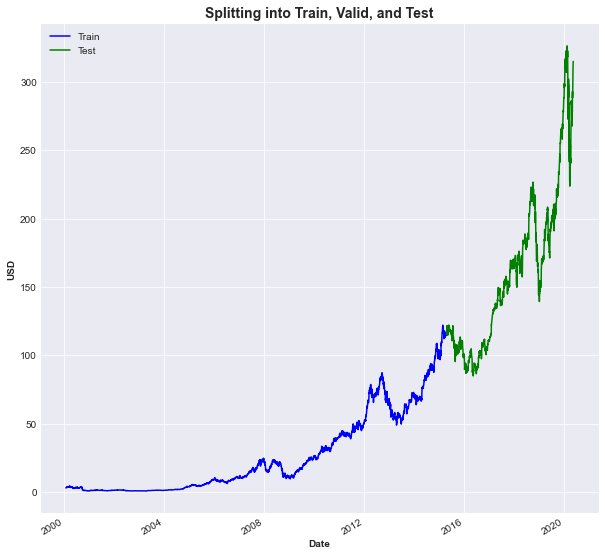

In [19]:
rcParams['figure.figsize'] = 10, 10

ax = train.plot(x='DATE', y='ADJ_CLOSE', style='b-', grid=True)
ax = test.plot(x='DATE', y='ADJ_CLOSE', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Test'])
ax.set_xlabel("Date", fontweight = 'bold')
ax.set_ylabel("USD", fontweight = 'bold')
ax.set_title("Splitting into Train, Valid, and Test", fontsize = 14, fontweight = 'bold');

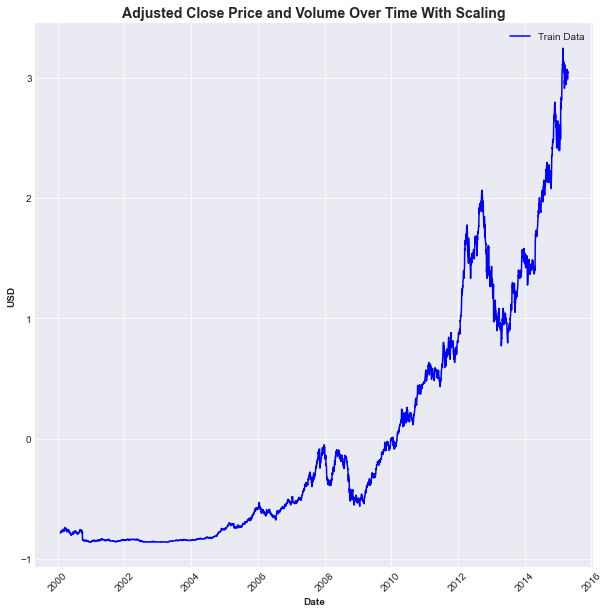

In [20]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train_df_scaled['DATE'], train_df_scaled['ADJ_CLOSE'], 'b-')
plt.legend(['Train Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time With Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [21]:
reg_model = LinearRegression(fit_intercept = True)

reg_model.fit(X_train_scaled, y_train_scaled)
est_train_scaled = reg_model.predict(X_train_scaled)
est_train = est_train_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

est_train_df = pd.DataFrame({'DATE':train['DATE'],
                                'PREDICTION': est_train})

print('R-Square Score:', r2_score(y_train, est_train))
print('Mean Square Score:', mean_squared_error(y_train, est_train))

R-Square Score: 0.9880890192816205
Mean Square Score: 10.38932094857425


In [22]:
est_train_df

,DATE,PREDICTION
21,2000-02-02,3.375120
22,2000-02-03,3.106015
23,2000-02-04,2.970081
24,2000-02-07,2.630293
25,2000-02-08,3.100692
...,...,...
3841,2015-04-13,112.786423
3842,2015-04-14,112.213054
3843,2015-04-15,113.768320
3844,2015-04-16,115.782925


In [35]:
train['ADJ_CLOSE']

21        3.055062
22        3.194192
23        3.339118
24        3.526558
25        3.551679
           ...    
3841    116.419769
3842    115.914986
3843    116.355522
3844    115.795677
3845    114.492439
Name: ADJ_CLOSE, Length: 3825, dtype: float64

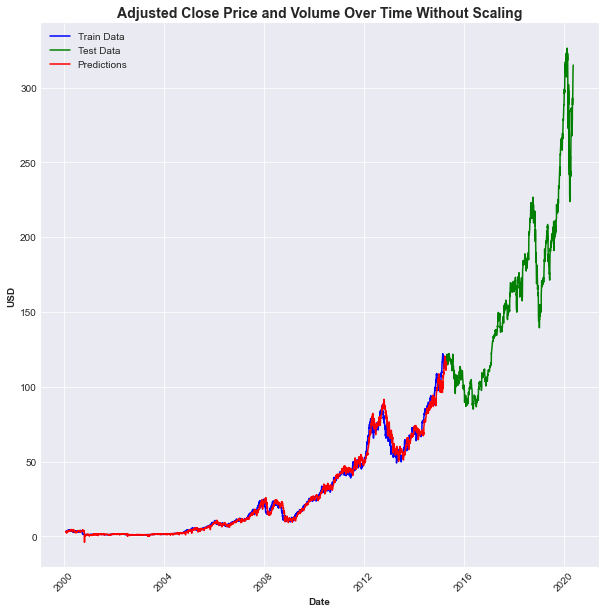

In [23]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(est_train_df['DATE'], est_train_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [46]:
est_test_scaled = reg_model.predict(X_test_scaled)
test['PREDICT_VALID'] = est_test_scaled
test['PREDICT'] = test['PREDICT_VALID'] * math.sqrt(test['ADJ_CLOSE_STD']) + test['ADJ_CLOSE_MEAN']

#* math.sqrt(scaler.var_[0]) + scaler.mean_[0]

est_test_df = pd.DataFrame({'DATE':test['DATE'],
                           'PREDICTION':test['PREDICT']})

print('R-Square Score:', r2_score(y_test, test['PREDICT']))
print('Mean Square Score:', mean_squared_error(y_test, test['PREDICT']))

R-Square Score: -4.513521140897868e+24
Mean Square Score: 1.4788324864693663e+28


<ipython-input-46-264c4c73a1e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT_VALID'] = est_test_scaled
<ipython-input-46-264c4c73a1e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT'] = test['PREDICT_VALID'] * math.sqrt(scaler.var_[1]) + scaler.mean_[1]


In [49]:
X_test_scaled

,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21,...,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21
3846,1.920689,1.570752,1.083127,1.063717,0.971257,1.920689,1.570752,1.083127,1.063717,0.971257,...,1.920689,1.570752,1.083127,1.063717,0.971257,1.920689,1.570752,1.083127,1.063717,0.971257
3847,3.406648,-0.403314,2.653328,2.053588,2.183950,3.406648,-0.403314,2.653328,2.053588,2.183950,...,3.406648,-0.403314,2.653328,2.053588,2.183950,3.406648,-0.403314,2.653328,2.053588,2.183950
3848,0.710611,0.715302,-0.004325,-0.416397,-0.023888,0.710611,0.715302,-0.004325,-0.416397,-0.023888,...,0.710611,0.715302,-0.004325,-0.416397,-0.023888,0.710611,0.715302,-0.004325,-0.416397,-0.023888
3849,0.681420,-0.082012,-0.674107,-0.578357,0.589365,0.681420,-0.082012,-0.674107,-0.578357,0.589365,...,0.681420,-0.082012,-0.674107,-0.578357,0.589365,0.681420,-0.082012,-0.674107,-0.578357,0.589365
3850,-0.273657,-2.216832,1.110260,2.091413,2.531415,-0.273657,-2.216832,1.110260,2.091413,2.531415,...,-0.273657,-2.216832,1.110260,2.091413,2.531415,-0.273657,-2.216832,1.110260,2.091413,2.531415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5116,-18.502866,-7.707054,-0.612201,-0.434947,0.631980,-18.502866,-7.707054,-0.612201,-0.434947,0.631980,...,-18.502866,-7.707054,-0.612201,-0.434947,0.631980,-18.502866,-7.707054,-0.612201,-0.434947,0.631980
5117,-9.573708,-7.569618,0.744266,1.945832,-12.779560,-9.573708,-7.569618,0.744266,1.945832,-12.779560,...,-9.573708,-7.569618,0.744266,1.945832,-12.779560,-9.573708,-7.569618,0.744266,1.945832,-12.779560
5118,-3.809275,-8.013568,0.759571,1.554220,9.148728,-3.809275,-8.013568,0.759571,1.554220,9.148728,...,-3.809275,-8.013568,0.759571,1.554220,9.148728,-3.809275,-8.013568,0.759571,1.554220,9.148728
5119,-4.452570,-5.267757,0.265583,-0.203799,-0.823980,-4.452570,-5.267757,0.265583,-0.203799,-0.823980,...,-4.452570,-5.267757,0.265583,-0.203799,-0.823980,-4.452570,-5.267757,0.265583,-0.203799,-0.823980


In [56]:
test[['ADJ_CLOSE', 'ADJ_CLOSE_STD', 'ADJ_CLOSE_MEAN', 'PREDICT_VALID', 'PREDICT']]

,ADJ_CLOSE,ADJ_CLOSE_STD,ADJ_CLOSE_MEAN,PREDICT_VALID,PREDICT
3846,117.108101,0.777107,115.795679,2.393687e+11,7.895254e+12
3847,116.474838,0.955744,115.933345,2.711442e+12,8.943327e+13
3848,118.044243,0.985390,116.045316,-2.805408e+09,-9.253260e+10
3849,119.007912,1.342861,116.383060,5.412961e+11,1.785392e+13
3850,119.567741,1.709842,117.025507,1.363362e+12,4.496867e+13
...,...,...,...,...,...
5116,296.756683,6.089351,287.689233,-7.776798e+12,-2.565072e+14
5117,299.818390,3.925369,291.474988,-1.274484e+12,-4.203714e+13
5118,302.919983,4.407322,294.048016,2.899889e+12,9.564891e+13
5119,310.130005,5.823907,296.030646,5.954744e+11,1.964092e+13


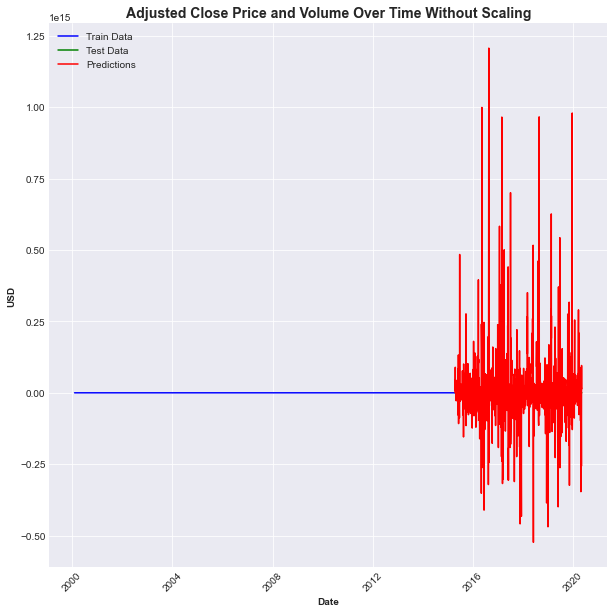

In [48]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(est_test_df['DATE'], est_test_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

## Split Data into Train and Test Data Frames (train_test_split)

In [27]:
AAPL_features = ['OPEN', 'CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']

y = AAPL_df.ADJ_CLOSE

X = AAPL_df[AAPL_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

## Linear Regression

In [105]:
AAPL_features = ['OPEN', 'CLOSE', 'VOLUME', 'MONTH', 'RANGE_HL', 'RANGE_OC']

y = AAPL_df.ADJ_CLOSE

X = AAPL_df[AAPL_features]

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
#train_y_scaled = scaler.fit_transform(train_y)
test_X_scaled = scaler.transform(test_X)

In [106]:
AAPL_LINmodel = LinearRegression()
AAPL_LINmodel.fit(train_X_scaled, train_y)

test_predictions_LIN = AAPL_LINmodel.predict(test_X_scaled)

test_predictions_LIN

array([32.48729753, -1.08584948, 85.72352897, ..., 64.89936347,
       -0.84509087, 29.69098341])

In [107]:
print('The Linear Regression Mean Absolute Error:', mean_absolute_error(test_y, test_predictions_LIN))

The Linear Regression Mean Absolute Error: 2.5125848355955367


In [108]:
absolute_error_LIN = []
for val, value in zip(test_predictions_LIN, test_y):
    absolute_error_LIN.append(abs(value - val))
    
absolute_error_LIN = np.array(absolute_error_LIN)
absolute_error_LIN

array([1.34693383, 2.49508066, 3.88309013, ..., 3.42835898, 2.30317248,
       1.13533842])

In [109]:
test_X['PREDICTIONS_LIN'] = test_predictions_LIN
test_X['ABS_ERROR_LIN'] = absolute_error_LIN
test_X

<ipython-input-109-f3d4397d5c49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['PREDICTIONS_LIN'] = test_predictions_LIN
<ipython-input-109-f3d4397d5c49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['ABS_ERROR_LIN'] = absolute_error_LIN


,OPEN,CLOSE,VOLUME,MONTH,RANGE_HL,RANGE_OC,PREDICTIONS_LIN,ABS_ERROR_LIN
2646,36.617142,35.971428,297731000.0,7,1.424286,0.645714,32.487298,1.346934
325,1.540714,1.627857,275210600.0,4,0.214286,-0.087143,-1.085849,2.495081
3641,90.209999,90.360001,36869000.0,6,1.049995,-0.150002,85.723529,3.883090
1224,3.940000,3.924286,73775800.0,11,0.051429,0.015714,1.185965,2.211279
2124,24.471428,25.262857,262932600.0,6,1.261429,-0.791430,22.293580,0.423591
...,...,...,...,...,...,...,...,...
948,1.695000,1.739286,69966400.0,10,0.049286,-0.044286,-0.901185,2.406880
3506,80.511429,80.792854,69567400.0,12,0.954292,-0.281425,76.221692,3.885800
3459,70.072861,69.058571,80688300.0,10,1.658577,1.014290,64.899363,3.428359
501,1.642857,1.684286,153001800.0,1,0.070000,-0.041429,-0.845091,2.303172


## Decision Tree Regressor

In [60]:
AAPL_features = ['HIGH', 'LOW', 'OPEN', 'CLOSE', 'VOLUME', 'MONTH', 'RANGE_HL', 'RANGE_OC']

y = AAPL_df.ADJ_CLOSE

X = AAPL_df[AAPL_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [61]:
AAPL_DTRmodel = DecisionTreeRegressor(random_state = 0)
AAPL_DTRmodel.fit(train_X, train_y)

val_predictions_DTR = AAPL_DTRmodel.predict(val_X)
val_predictions_DTR

array([31.2096138 ,  1.41046858, 79.03473663, ..., 61.15691757,
        1.45684505, 28.73990631])

In [62]:
print('The Decision Tree Regression Mean Absolute Error:', mean_absolute_error(val_y, val_predictions_DTR))

The Decision Tree Regression Mean Absolute Error: 0.4256947008542768


In [63]:
absolute_error_DTR = []
for val, value in zip(val_predictions_DTR, val_y):
    absolute_error_DTR.append(abs(value - val))
    
absolute_error_DTR = np.array(absolute_error_DTR)
absolute_error_DTR

array([6.92501068e-02, 1.23739243e-03, 2.80570221e+00, ...,
       3.14086914e-01, 1.23655796e-03, 1.84261322e-01])

In [64]:
val_X

,HIGH,LOW,OPEN,CLOSE,VOLUME,MONTH,RANGE_HL,RANGE_OC
2646,36.628571,35.204285,36.617142,35.971428,297731000.0,7,1.424286,0.645714
325,1.720000,1.505714,1.540714,1.627857,275210600.0,4,0.214286,-0.087143
3641,90.699997,89.650002,90.209999,90.360001,36869000.0,6,1.049995,-0.150002
1224,3.942857,3.891428,3.940000,3.924286,73775800.0,11,0.051429,0.015714
2124,25.414286,24.152857,24.471428,25.262857,262932600.0,6,1.261429,-0.791430
...,...,...,...,...,...,...,...,...
948,1.743571,1.694286,1.695000,1.739286,69966400.0,10,0.049286,-0.044286
3506,81.125717,80.171425,80.511429,80.792854,69567400.0,12,0.954292,-0.281425
3459,70.335716,68.677139,70.072861,69.058571,80688300.0,10,1.658577,1.014290
501,1.696429,1.626429,1.642857,1.684286,153001800.0,1,0.070000,-0.041429


In [65]:
val_X['PREDICTIONS_DTR'] = val_predictions_DTR
val_X['ABS_ERROR_DTR'] = absolute_error_DTR
val_X

<ipython-input-65-22c011993b6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X['PREDICTIONS_DTR'] = val_predictions_DTR
<ipython-input-65-22c011993b6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X['ABS_ERROR_DTR'] = absolute_error_DTR


,HIGH,LOW,OPEN,CLOSE,VOLUME,MONTH,RANGE_HL,RANGE_OC,PREDICTIONS_DTR,ABS_ERROR_DTR
2646,36.628571,35.204285,36.617142,35.971428,297731000.0,7,1.424286,0.645714,31.209614,0.069250
325,1.720000,1.505714,1.540714,1.627857,275210600.0,4,0.214286,-0.087143,1.410469,0.001237
3641,90.699997,89.650002,90.209999,90.360001,36869000.0,6,1.049995,-0.150002,79.034737,2.805702
1224,3.942857,3.891428,3.940000,3.924286,73775800.0,11,0.051429,0.015714,3.394770,0.002474
2124,25.414286,24.152857,24.471428,25.262857,262932600.0,6,1.261429,-0.791430,21.856388,0.013601
...,...,...,...,...,...,...,...,...,...,...
948,1.743571,1.694286,1.695000,1.739286,69966400.0,10,0.049286,-0.044286,1.503840,0.001855
3506,81.125717,80.171425,80.511429,80.792854,69567400.0,12,0.954292,-0.281425,72.607063,0.271172
3459,70.335716,68.677139,70.072861,69.058571,80688300.0,10,1.658577,1.014290,61.156918,0.314087
501,1.696429,1.626429,1.642857,1.684286,153001800.0,1,0.070000,-0.041429,1.456845,0.001237


## Random Forest Regressor

In [72]:
AAPL_features = ['HIGH', 'LOW', 'OPEN', 'CLOSE', 'VOLUME', 'MONTH', 'RANGE_HL', 'RANGE_OC']

y = AAPL_df.ADJ_CLOSE

X = AAPL_df[AAPL_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [73]:
AAPL_RANmodel = RandomForestRegressor(random_state = 1)
AAPL_RANmodel.fit(train_X, train_y)

val_predictions_RAN = AAPL_RANmodel.predict(val_X)
val_predictions_RAN

array([31.16123102,  1.40853372, 81.24151688, ..., 61.2466209 ,
        1.45406782, 28.40759623])

In [74]:
print('The Random Forest Regression Mean Absolute Error:', mean_absolute_error(val_y, val_predictions_RAN))

The Random Forest Regression Mean Absolute Error: 0.3731786314501053


In [75]:
absolute_error_RAN = []
for val, value in zip(val_predictions_RAN, val_y):
    absolute_error_RAN.append(abs(value - val))
    
absolute_error_RAN = np.array(absolute_error_RAN)
absolute_error_RAN

array([0.02086733, 0.00069746, 0.59892197, ..., 0.22438358, 0.00401378,
       0.14804876])

In [76]:
val_X

,HIGH,LOW,OPEN,CLOSE,VOLUME,MONTH,RANGE_HL,RANGE_OC
2646,36.628571,35.204285,36.617142,35.971428,297731000.0,7,1.424286,0.645714
325,1.720000,1.505714,1.540714,1.627857,275210600.0,4,0.214286,-0.087143
3641,90.699997,89.650002,90.209999,90.360001,36869000.0,6,1.049995,-0.150002
1224,3.942857,3.891428,3.940000,3.924286,73775800.0,11,0.051429,0.015714
2124,25.414286,24.152857,24.471428,25.262857,262932600.0,6,1.261429,-0.791430
...,...,...,...,...,...,...,...,...
948,1.743571,1.694286,1.695000,1.739286,69966400.0,10,0.049286,-0.044286
3506,81.125717,80.171425,80.511429,80.792854,69567400.0,12,0.954292,-0.281425
3459,70.335716,68.677139,70.072861,69.058571,80688300.0,10,1.658577,1.014290
501,1.696429,1.626429,1.642857,1.684286,153001800.0,1,0.070000,-0.041429


In [77]:
val_X['PREDICTIONS_RAN'] = val_predictions_RAN
val_X['ABS_ERROR_RAN'] = absolute_error_RAN
val_X

<ipython-input-77-d09f97187d4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X['PREDICTIONS_RAN'] = val_predictions_RAN
<ipython-input-77-d09f97187d4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X['ABS_ERROR_RAN'] = absolute_error_RAN


,HIGH,LOW,OPEN,CLOSE,VOLUME,MONTH,RANGE_HL,RANGE_OC,PREDICTIONS_RAN,ABS_ERROR_RAN
2646,36.628571,35.204285,36.617142,35.971428,297731000.0,7,1.424286,0.645714,31.161231,0.020867
325,1.720000,1.505714,1.540714,1.627857,275210600.0,4,0.214286,-0.087143,1.408534,0.000697
3641,90.699997,89.650002,90.209999,90.360001,36869000.0,6,1.049995,-0.150002,81.241517,0.598922
1224,3.942857,3.891428,3.940000,3.924286,73775800.0,11,0.051429,0.015714,3.396264,0.000980
2124,25.414286,24.152857,24.471428,25.262857,262932600.0,6,1.261429,-0.791430,21.862644,0.007345
...,...,...,...,...,...,...,...,...,...,...
948,1.743571,1.694286,1.695000,1.739286,69966400.0,10,0.049286,-0.044286,1.505805,0.000110
3506,81.125717,80.171425,80.511429,80.792854,69567400.0,12,0.954292,-0.281425,72.202071,0.133821
3459,70.335716,68.677139,70.072861,69.058571,80688300.0,10,1.658577,1.014290,61.246621,0.224384
501,1.696429,1.626429,1.642857,1.684286,153001800.0,1,0.070000,-0.041429,1.454068,0.004014
